In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import scipy.stats as stat
from itertools import groupby
from datetime import  timedelta,datetime
import matplotlib.pyplot as plt
R = 6.371*10**6

def unique(list1):
  # intilize a null list
  unique_list = []
  # traverse for all elements
  for x in list1:
      # check if exists in unique_list or not
      if x not in unique_list:
          unique_list.append(x)
  return unique_list

def cartesian(lat,lon):
  lat = lat/180*math.pi
  lon = lon/180*math.pi
  z = R*np.sin(lat)
  u = R*np.cos(lat)
  x = u*np.cos(lon)
  y = u*np.sin(lon)
  return x,y,z

def great_circle_dist(lat1,lon1,lat2,lon2):
  lat1 = lat1/180*math.pi
  lon1 = lon1/180*math.pi
  lat2 = lat2/180*math.pi
  lon2 = lon2/180*math.pi
  temp = np.cos(lat1)*np.cos(lat2)*np.cos(lon1-lon2)+np.sin(lat1)*np.sin(lat2)
  if isinstance(temp,np.ndarray):
    temp[temp>1]=1
    temp[temp<-1]=-1
  else:
    if temp>1:
      temp=1
    if temp<-1:
      temp=-1
  theta = np.arccos(temp)
  d = theta*R
  return d

def shortest_dist_to_great_circle(lat,lon,lat_start,lon_start,lat_end,lon_end):
  if abs(lat_start-lat_end)<1e-6 and abs(lon_start-lon_end)<1e-6:
    return np.zeros(len(lat))
  else:
    x,y,z = cartesian(lat,lon)
    x_start,y_start,z_start = cartesian(lat_start,lon_start)
    x_end,y_end,z_end = cartesian(lat_end,lon_end)
    cross_product = np.cross(np.array([x_start,y_start,z_start]),np.array([x_end,y_end,z_end]))
    N = cross_product/(np.linalg.norm(cross_product)+1e-6)
    C = np.array([x,y,z])/R
    temp = np.dot(N,C)
    if isinstance(temp,np.ndarray):
      temp[temp>1]=1
      temp[temp<-1]=-1
    else:
      if temp>1:
        temp=1
      if temp<-1:
        temp=-1
    NOC = np.arccos(temp)
    d = abs(math.pi/2-NOC)*R
    return d

def pairwise_great_circle_dist(latlon_array):
  dist = []
  k = np.shape(latlon_array)[0]
  for i in range(k-1):
    for j in np.arange(i+1,k):
      dist.append(great_circle_dist(latlon_array[i,0],latlon_array[i,1],latlon_array[j,0],latlon_array[j,1]))
  return dist

def ExistKnot(mat,r,w):
  n = mat.shape[0]
  if n>1:
    lat_start = mat[0,2]
    lon_start = mat[0,3]
    lat_end = mat[n-1,2]
    lon_end = mat[n-1,3]
    lat = mat[:,2]
    lon = mat[:,3]
    d = shortest_dist_to_great_circle(lat,lon,lat_start,lon_start,lat_end,lon_end)
    if max(d)<w:
      return 0, None
    else:
      return 1, np.argmax(d)
  else:
    return 0, None

def ExtractFlights(mat,itrvl,r,w,h):
  if len(mat.shape)==1:
    out = np.array([3,mat[2],mat[3],mat[1]-itrvl/2,None,None,mat[1]+itrvl/2])
  elif len(mat.shape)==2 and mat.shape[0]==1:
    out = np.array([3,mat[0,2],mat[0,3],mat[0,1]-itrvl/2,None,None,mat[0,1]+itrvl/2])
  else:
    n = mat.shape[0]
    mat = np.hstack((mat,np.arange(n).reshape((n,1))))
    if n>1 and max(pairwise_great_circle_dist(mat[:,2:4]))<r:
      m_lon = (mat[0,2]+mat[n-1,2])/2
      m_lat = (mat[0,3]+mat[n-1,3])/2
      out = np.array([2,m_lon,m_lat,mat[0,1]-itrvl/2,m_lon,m_lat,mat[n-1,1]+itrvl/2])
    else:
      complete = 0
      knots = [0,n-1]
      mov = np.array([great_circle_dist(mat[i,2],mat[i,3],mat[i+1,2],mat[i+1,3]) for i in range(n-1)])
      pause_index = np.arange(0,n-1)[mov<h]
      temp = []
      for j in range(len(pause_index)-1):
        if pause_index[j+1]-pause_index[j]==1:
          temp.append(pause_index[j])
          temp.append(pause_index[j+1])
      ## all the consequential numbers in between are inserted twice, but start and end are inserted once
      long_pause = np.unique(temp)[np.array([len(list(group)) for key, group in groupby(temp)])==1]
      ## pause 0,1,2, correspond to point [0,1,2,3], so the end number should plus 1
      long_pause[np.arange(1,len(long_pause),2)] = long_pause[np.arange(1,len(long_pause),2)]+1
      knots.extend(long_pause.tolist())
      knots.sort()
      knots = unique(knots)
      while complete == 0:
        mat_list = []
        for i in range(len(knots)-1):
          mat_list.append(mat[knots[i]:min(knots[i+1]+1,n-1),:])
        knot_yes = np.empty(len(mat_list))
        knot_pos = np.empty(len(mat_list))
        for i in range(len(mat_list)):
          knot_yes[i] , knot_pos[i] = ExistKnot(mat_list[i],r,w)
        if sum(knot_yes)==0:
          complete = 1
        else:
          for i in range(len(mat_list)):
            if knot_yes[i]==1:
              knots.append(int((mat_list[i])[int(knot_pos[i]),4]))
          knots.sort()
      out = []
      for j in range(len(knots)-1):
        start = knots[j]
        end = knots[j+1]
        mov = np.array([great_circle_dist(mat[i,2],mat[i,3],mat[i+1,2],mat[i+1,3]) for i in np.arange(start,end)])
        if sum(mov>=h)==0:
          m_lon = (mat[start,2]+mat[end,2])/2
          m_lat = (mat[start,3]+mat[end,3])/2
          nextline = [2, m_lon,m_lat,mat[start,1],m_lon,m_lat,mat[end,1]]
        else:
          nextline = [1, mat[start,2],mat[start,3],mat[start,1],mat[end,2],mat[end,3],mat[end,1]]
        out.append(nextline)
      out = np.array(out)
  return out

def GPS2MobMat(filelist,itrvl=10,accuracylim=51, r=None, w=None,h=None):
  if r is None:
    r = itrvl
    #r = np.sqrt(itrvl)
  if h is None:
    h = r
  data = pd.DataFrame()
  sys.stdout.write("Read in all GPS csv files..." + '\n')
  for i in range(len(filelist)):
    df = pd.read_csv(filelist[i])
    data = data.append(df)
  data = data[data.accuracy<accuracylim]
  if w is None:
    w = np.mean(data.accuracy)
    #w = np.mean(data.accuracy)+itrvl
  t_start = np.array(data.timestamp)[0]/1000
  t_end = np.array(data.timestamp)[-1]/1000
  avgmat = np.empty([int(np.ceil((t_end-t_start)/itrvl))+2,4])
  sys.stdout.write("Collapse data within " +str(itrvl)+" second intervals..."+'\n')
  IDam = 0
  count = 0
  nextline=[1,t_start+itrvl/2,data.iloc[0,2],data.iloc[0,3]]
  numitrvl=1
  for i in np.arange(1,data.shape[0]):
    if data.iloc[i,0]/1000 < t_start+itrvl:
      nextline[2]=nextline[2]+data.iloc[i,2]
      nextline[3]=nextline[3]+data.iloc[i,3]
      numitrvl=numitrvl+1
    else:
      nextline[2]=nextline[2]/numitrvl
      nextline[3]=nextline[3]/numitrvl
      avgmat[IDam,:]=nextline
      count=count+1
      IDam=IDam+1
      nummiss=int(np.floor((data.iloc[i,0]/1000-(t_start+itrvl))/itrvl))
      if nummiss>0:
        avgmat[IDam,:] = [4,t_start+itrvl,t_start+itrvl*(nummiss+1),None]
        count=count+1
        IDam=IDam+1
      t_start=t_start+itrvl*(nummiss+1)
      nextline[0]=1
      nextline[1]=t_start+itrvl/2
      nextline[2]=data.iloc[i,2]
      nextline[3]=data.iloc[i,3]
      numitrvl=1

  avgmat = avgmat[0:count,:]
  ID1 = avgmat[:,0]==1
  outmat = np.zeros(7)
  curind = 0
  sys.stdout.write("Extract flights and pauses ..."+'\n')
  for i in range(avgmat.shape[0]):
    if avgmat[i,0]==4:
      #print(curind,i)
      temp = ExtractFlights(avgmat[np.arange(curind,i),:],itrvl,r,w,h)
      outmat = np.vstack((outmat,temp))
      curind=i+1
  if curind<avgmat.shape[0]:
    #print(np.arange(curind,avgmat.shape[0]))
    temp = ExtractFlights(avgmat[np.arange(curind,avgmat.shape[0]),:],itrvl,r,w,h)
    outmat = np.vstack((outmat,temp))

  mobmat = np.delete(outmat,0,0)
  return mobmat

def InferMobMat(mobmat,itrvl=10,r=None):
  ## infer those unclassified pieces
  sys.stdout.write("Infer unclassified windows ..."+'\n')
  if r is None:
    r = itrvl
    #r = np.sqrt(itrvl)
  code = mobmat[:,0]
  x0 = mobmat[:,1]; y0 = mobmat[:,2]; t0 = mobmat[:,3]
  x1 = mobmat[:,4]; y1 = mobmat[:,5]; t1 = mobmat[:,6]

  for i in range(len(code)):
    if code[i]==3 and i==0:
      code[i]=2
      x1[i] = x0[i]
      y1[i] = y0[i]
    if code[i]==3 and i>0:
      d = great_circle_dist(x0[i],y0[i],x1[i-1],y1[i-1])
      if t0[i]-t1[i-1]<=itrvl*3:
        if d<r:
          code[i]=2
          x1[i] = x0[i]
          y1[i] = y0[i]
        else:
          code[i]=1
          s_x = x0[i]-itrvl/2/(t0[i]-t1[i-1])*(x0[i]-x1[i-1])
          s_y = y0[i]-itrvl/2/(t0[i]-t1[i-1])*(y0[i]-y1[i-1])
          e_x = x0[i]+itrvl/2/(t0[i]-t1[i-1])*(x0[i]-x1[i-1])
          e_y = y0[i]+itrvl/2/(t0[i]-t1[i-1])*(y0[i]-y1[i-1])
          x0[i] = s_x; x1[i]=e_x
          y0[i] = s_y; y1[i]=e_y
      if t0[i]-t1[i-1]>itrvl*3:
        if (i+1)<len(code):
          f = great_circle_dist(x0[i],y0[i],x0[i+1],y0[i+1])
          if t0[i+1]-t1[i]<=itrvl*3:
            if f<r:
              code[i]=2
              x1[i] = x0[i]
              y1[i] = y0[i]
            else:
              code[i]=1
              s_x = x0[i]-itrvl/2/(t0[i+1]-t1[i])*(x0[i+1]-x0[i])
              s_y = y0[i]-itrvl/2/(t0[i+1]-t1[i])*(y0[i+1]-y0[i])
              e_x = x0[i]+itrvl/2/(t0[i+1]-t1[i])*(x0[i+1]-x0[i])
              e_y = y0[i]+itrvl/2/(t0[i+1]-t1[i])*(y0[i+1]-y0[i])
              x0[i] = s_x; x1[i]=e_x
              y0[i] = s_y; y1[i]=e_y
          else:
            code[i]=2
            x1[i] = x0[i]
            y1[i] = y0[i]
        else:
          code[i]=2
          x1[i] = x0[i]
          y1[i] = y0[i]
    mobmat[i,:] = [code[i],x0[i],y0[i],t0[i],x1[i],y1[i],t1[i]]

  ## merge consecutive pauses
  sys.stdout.write("Merge consecutive pauses and bridge gaps ..."+'\n')
  k = []
  for j in np.arange(1,len(code)):
    if code[j]==2 and code[j-1]==2 and t0[j]==t1[j-1]:
      k.append(j-1)
      k.append(j)
  ## all the consequential numbers in between are inserted twice, but start and end are inserted once
  rk = np.unique(k)[np.array([len(list(group)) for key, group in groupby(k)])==1]
  for j in range(int(len(rk)/2)):
    start = rk[2*j]
    end = rk[2*j+1]
    mx = np.mean(x0[np.arange(start,end+1)])
    my = np.mean(y0[np.arange(start,end+1)])
    mobmat[start,:] = [2,mx,my,t0[start],mx,my,t1[end]]
    mobmat[np.arange(start+1,end+1),0]=5
  mobmat = mobmat[mobmat[:,0]!=5,:]

  ## check missing intervals, if starting and ending point are close, make them same
  for j in np.arange(1,mobmat.shape[0]):
    if mobmat[j,3] > mobmat[j-1,6]:
      d = great_circle_dist(mobmat[j,1],mobmat[j,2],mobmat[j-1,4],mobmat[j-1,5])
      if d<5:
        if mobmat[j,0]==2 and mobmat[j-1,0]==2:
          mean_x = (mobmat[j,1] + mobmat[j-1,4])/2
          mean_y = (mobmat[j,2] + mobmat[j-1,5])/2
          mobmat[j,1] = mobmat[j,4] = mobmat[j-1,1] = mobmat[j-1,4] = mean_x
          mobmat[j,2] = mobmat[j,5] = mobmat[j-1,2] = mobmat[j-1,5] = mean_y
        if mobmat[j,0]==1 and mobmat[j-1,0]==2:
          mobmat[j,1] = mobmat[j-1,4]
          mobmat[j,2] = mobmat[j-1,5]
        if mobmat[j,0]==2 and mobmat[j-1,0]==1:
          mobmat[j-1,4] = mobmat[j,1]
          mobmat[j-1,5] = mobmat[j,2]
        if mobmat[j,0]==1 and mobmat[j-1,0]==1:
          mean_x = (mobmat[j,1] + mobmat[j-1,4])/2
          mean_y = (mobmat[j,2] + mobmat[j-1,5])/2
          mobmat[j-1,4] = mobmat[j,1] = mean_x
          mobmat[j-1,5] = mobmat[j,2] = mean_y

  ## connect flights and pauses
  for j in np.arange(1,mobmat.shape[0]):
    if mobmat[j,0]*mobmat[j-1,0]==2 and mobmat[j,3]==mobmat[j-1,6]:
      if mobmat[j,0]==1:
        mobmat[j,1] = mobmat[j-1,4]
        mobmat[j,2] = mobmat[j-1,5]
      if mobmat[j-1,0]==1:
        mobmat[j-1,4] = mobmat[j,1]
        mobmat[j-1,5] = mobmat[j,2]
  return mobmat

def K0(x1,x2):
  k1 = np.exp(-abs(x1[0]-x2[0])/l1)*np.exp(-(np.sin(abs(x1[0]-x2[0])/86400*math.pi))**2/a1)
  k2 = np.exp(-abs(x1[0]-x2[0])/l2)*np.exp(-(np.sin(abs(x1[0]-x2[0])/604800*math.pi))**2/a2)
  k3 = np.exp(-abs(x1[1]-x2[1])/l3)
  return b1*k1+b2*k2+b3*k3

## similarity matrix between bv's
def update_K(bv,t,K,X):
  if t==0:
    mat = np.array([1])
  else:
    d = np.shape(K)[0]
    row = np.ones(d)
    column = np.ones([d+1,1])
    if X.ndim==1:
      for i in range(d):
        row[i] = column[i,0] = K0(X[t],X[bv[i]])
    else:
      for i in range(d):
        row[i] = column[i,0] = K0(X[t,:],X[bv[i],:])
    mat = np.hstack([np.vstack([K,row]),column])
  return mat

## similarity vector between the t'th input with all bv's, t starts from 0 here
def update_k(bv,t,X):
  d = len(bv)
  if d==0:
    out = np.array([0])
  if d>=1:
    out = np.zeros(d)
    if X.ndim==1:
      for i in range(d):
        out[i] = K0(X[t],X[bv[i]])
    else:
      for i in range(d):
        out[i] = K0(X[t,:],X[bv[i],:])
  return out

def update_e_hat(Q,k):
  if np.shape(Q)[0]==0:
    out = np.array([0])
  else:
    out = np.dot(Q,k)
  return out

def update_gamma(k,e_hat):
  return 1-np.dot(k,e_hat)

def update_q(t,k,alpha,sigmax,Y):
  if t==0:
    out = Y[t]/sigmax
  else:
    out = (Y[t]-np.dot(k,alpha))/sigmax
  return out

def update_s_hat(C,k,e_hat):
  return np.dot(C,k)+e_hat

def update_eta(gamma,sigmax):
  r = -1/sigmax
  return 1/(1+gamma*r)

def update_alpha_hat(alpha,q,eta,s_hat):
  return alpha+q*eta*s_hat

def update_c_hat(C,sigmax,eta,s_hat):
  r = -1/sigmax
  return C+r*eta*np.outer(s_hat,s_hat)

def update_s(C,k):
  if np.shape(C)[0]==0:
    s = np.array([1])
  else:
    temp = np.dot(C,k)
    s = np.append(temp,1)
  return s

def update_alpha(alpha,q,s):
  T_alpha = np.append(alpha,0)
  new_alpha = T_alpha + q*s
  return new_alpha

def update_c(C,sigmax,s):
  d = np.shape(C)[0]
  if d==0:
    U_c = np.array([0])
  else:
    U_c = np.hstack([np.vstack([C,np.zeros(d)]),np.zeros([d+1,1])])
  r = -1/sigmax
  new_c = U_c+r*np.outer(s,s)
  return new_c

def update_Q(Q,gamma,e_hat):
  d = np.shape(Q)[0]
  if d==0:
    out = np.array([1])
  else:
    temp = np.append(e_hat,-1)
    new_Q = np.hstack([np.vstack([Q,np.zeros(d)]),np.zeros([d+1,1])])
    out = new_Q + 1/gamma*np.outer(temp,temp)
  return out

def update_alpha_vec(alpha,Q,C):
  t = len(alpha)-1
  return alpha[:t]-alpha[t]/(C[t,t]+Q[t,t])*(Q[t,:t]+C[t,:t])

def update_c_mat(C,Q):
  t = np.shape(C)[0]-1
  return C[:t,:t]+np.outer(Q[t,:t],Q[t,:t])/Q[t,t]-np.outer(Q[t,:t]+C[t,:t],Q[t,:t]+C[t,:t])/(Q[t,t]+C[t,t])

def update_q_mat(Q):
  t = np.shape(Q)[0]-1
  return Q[:t,:t]-np.outer(Q[t,:t],Q[t,:t])/Q[t,t]

def update_s_mat(k_mat,s_mat,index,Q):
  k_mat =  (k_mat[index,:])[:,index]
  s_mat =  (s_mat[index,:])[:,index]
  step1 = k_mat-k_mat.dot(s_mat).dot(k_mat)
  step2 = (step1[:d,:])[:,:d]
  step3 = Q - Q.dot(step2).dot(Q)
  return step3

def SOGP(X,Y,sigma2,tol,d,Q=[],C=[],alpha=[],bv=[]):
  n = len(Y)
  I = 0 ## an indicator shows if it is the first time that the number of bvs hits d
  for i in range(n):
    k = update_k(bv,i,X)
    if np.shape(C)[0]==0:
      sigmax = 1+sigma2
    else:
      sigmax = 1+sigma2+k.dot(C).dot(k)
    q = update_q(i,k,alpha,sigmax,Y)
    r = -1/sigmax
    e_hat = update_e_hat(Q,k)
    gamma = update_gamma(k,e_hat)
    if gamma<tol:
      s = update_s_hat(C,k,e_hat)
      eta = update_eta(gamma,sigmax)
      alpha = update_alpha_hat(alpha,q,eta,s)
      C = update_c_hat(C,sigmax,eta,s)
    else:
      s = update_s(C,k)
      alpha = update_alpha(alpha,q,s)
      C = update_c(C,sigmax,s)
      Q = update_Q(Q,gamma,e_hat)

      bv = np.array(np.append(bv,i),dtype=int)
      if len(bv)>=d:
        I = I + 1
      if I==1:
        K = np.zeros([d,d])
        if X.ndim==1:
          for i in range(d):
            for j in range(d):
              K[i,j] = K0(X[bv[i]],X[bv[j]])
        else:
          for i in range(d):
            for j in range(d):
              K[i,j] = K0(X[bv[i],:],X[bv[j],:])
        S = np.linalg.inv(np.linalg.inv(C)+K)

      if len(bv)>d:
        alpha_vec = update_alpha_vec(alpha,Q,C)
        c_mat = update_c_mat(C,Q)
        q_mat = update_q_mat(Q)
        s_mat = np.hstack([np.vstack([S,np.zeros(d)]),np.zeros([d+1,1])])
        s_mat[d,d] = 1/sigma2
        k_mat = update_K(bv,i,K,X)
        eps = np.zeros(d)
        for j in range(d):
          eps[j] = alpha_vec[j]/(q_mat[j,j]+c_mat[j,j])-s_mat[j,j]/q_mat[j,j]+np.log(1+c_mat[j,j]/q_mat[j,j])
        loc = np.where(eps == np.min(eps))[0][0]
        bv = np.array(np.delete(bv,loc),dtype=int)
        if loc==0:
          index = np.append(np.arange(1,d+1),0)
        else:
          index = np.append(np.append(np.arange(0,loc),np.arange(loc+1,d+1)),loc)
        alpha = update_alpha_vec(alpha[index],(Q[index,:])[:,index],(C[index,:])[:,index])

        C = update_c_mat((C[index,:])[:,index],(Q[index,:])[:,index])
        Q = update_q_mat((Q[index,:])[:,index])
        S = update_s_mat(k_mat,s_mat,index,Q)
        K = (k_mat[index[:d],:])[:,index[:d]]
  output = {'bv':bv,'alpha':alpha,'Q':Q,'C':C}
  return output

def BV_select(MobMat,sigma2,tol,d):
  mean_x = (MobMat[:,1]+MobMat[:,4])/2
  mean_y = (MobMat[:,2]+MobMat[:,5])/2
  mean_t = (MobMat[:,3]+MobMat[:,6])/2
  X = np.transpose(np.vstack((mean_t,mean_x)))
  Y = mean_y
  result1 = SOGP(X,Y,sigma2,tol,d)['bv']
  X = np.transpose(np.vstack((mean_t,mean_y)))
  Y = mean_x
  result2 = SOGP(X,Y,sigma2,tol,d)['bv']
  index = np.unique(np.append(result1,result2))
  BV_set = MobMat[index,:]
  return {'BV_set':BV_set,'BV_index':index}

def create_tables(MobMat, BV_set):
  n = np.shape(MobMat)[0]
  m = np.shape(BV_set)[0]
  index = [BV_set[i,0]==1 for i in range(m)]
  flight_table = BV_set[index,:]
  index = [BV_set[i,0]==2 for i in range(m)]
  pause_table = BV_set[index,:]
  mis_table = np.zeros(8)
  for i in range(n-1):
    if MobMat[i+1,3]!=MobMat[i,6]:
      ## also record if it's flight/pause before and after the missing interval
      mov = np.array([MobMat[i,4],MobMat[i,5],MobMat[i,6],MobMat[i+1,1],MobMat[i+1,2],MobMat[i+1,3],MobMat[i,0],MobMat[i+1,0]])
      mis_table = np.vstack((mis_table,mov))
  mis_table = np.delete(mis_table,0,0)
  return flight_table, pause_table, mis_table

def K1(method,current_t,current_x,current_y,BV_set):
  mean_x = ((BV_set[:,1] + BV_set[:,4])/2).astype(float)
  mean_y = ((BV_set[:,2] + BV_set[:,5])/2).astype(float)
  mean_t = ((BV_set[:,3] + BV_set[:,6])/2).astype(float)
  if method=="TL":
    k1 = np.exp(-abs(current_t-mean_t)/l1)*np.exp(-(np.sin(abs(current_t-mean_t)/86400*math.pi))**2/a1)
    k2 = np.exp(-abs(current_t-mean_t)/l2)*np.exp(-(np.sin(abs(current_t-mean_t)/604800*math.pi))**2/a2)
    return b1/(b1+b2)*k1+b2/(b1+b2)*k2
  if method=="GL":
    d = great_circle_dist(current_x,current_y,mean_x,mean_y)
    return np.exp(-d/g)
  if method=="GLC":
    k1 = np.exp(-abs(current_t-mean_t)/l1)*np.exp(-(np.sin(abs(current_t-mean_t)/86400*math.pi))**2/a1)
    k2 = np.exp(-abs(current_t-mean_t)/l2)*np.exp(-(np.sin(abs(current_t-mean_t)/604800*math.pi))**2/a2)
    d = great_circle_dist(current_x,current_y,mean_x,mean_y)
    k3 = np.exp(-d/g)
    return b1*k1+b2*k2+b3*k3

def I_flight(method,current_t,current_x,current_y,dest_t,dest_x,dest_y,BV_set,z):
  K = K1(method,current_t,current_x,current_y,BV_set)
  flight_K = K[BV_set[:,0]==1]
  pause_K = K[BV_set[:,0]==2]
  sorted_flight = np.sort(flight_K)[::-1]
  sorted_pause = np.sort(pause_K)[::-1]
  p0 = np.mean(sorted_flight[0:num])/(np.mean(sorted_flight[0:num])+np.mean(sorted_pause[0:num])+1e-8)
  d_dest = great_circle_dist(current_x,current_y,dest_x,dest_y)
  v_dest = d_dest/(dest_t-current_t+0.0001)
  ## design an exponential function here to adjust the probability based on the speed needed
  ## p = p0*exp(|v-2|+/s)  v=2--p=p0   v=14--p=1
  if p0 < 1e-5:
    p0 = 1e-5
  if p0 > 1-1e-5:
    p0 = 1-1e-5
  s = -12/np.log(p0)
  p1 = min(1,p0*np.exp(min(max(0,v_dest-2)/s,1e2)))
  out = stat.bernoulli.rvs(p1,size=z)
  return out

def adjust_direction(delta_x,delta_y,start_x,start_y,end_x,end_y,origin_x,origin_y,dest_x,dest_y):
  norm1 = np.sqrt((dest_x-origin_x)**2+(dest_y-origin_y)**2)
  k = np.random.uniform(low=0, high=4) ## this is another parameter which controls the smoothness
  new_x = delta_x + k*(dest_x-origin_x)/norm1
  new_y = delta_y + k*(dest_y-origin_y)/norm1
  norm2 = np.sqrt(delta_x**2 + delta_y**2)
  norm3 = np.sqrt(new_x**2 + new_y**2)
  norm_x = new_x*norm2/norm3
  norm_y = new_y*norm2/norm3
  inner = np.inner(np.array([end_x-start_x,end_y-start_y]),np.array([norm_x,norm_y]))
  if inner < 0:
    return -norm_x, -norm_y
  else:
    return norm_x, norm_y

def multiplier(t_diff):
  if t_diff<=10*60:
    return 1
  elif t_diff<=60*60:
    return 5
  elif t_diff<=720*60:
    return 10
  else:
    return 50

def checkbound(current_x,current_y,start_x,start_y,end_x,end_y):
  max_x = max(start_x,end_x)
  min_x = min(start_x,end_x)
  max_y = max(start_y,end_y)
  min_y = min(start_y,end_y)
  if current_x<max_x+0.01 and current_x>min_x-0.01 and current_y<max_y+0.01 and current_y>min_y-0.01:
    return 1
  else:
    return 0

def ImputeGPS(MobMat,BV_set,method,switch):
  sys.stdout.write("Imputing missing trajectories..." + '\n')
  flight_table, pause_table, mis_table = create_tables(MobMat, BV_set)
  imp_x0 = np.array([]); imp_x1 = np.array([])
  imp_y0 = np.array([]); imp_y1 = np.array([])
  imp_t0 = np.array([]); imp_t1 = np.array([])
  imp_s = np.array([])

  for i in range(mis_table.shape[0]):
     ## if a person remains at the same place at the begining and end of missing, just assume he satys there all the time
    if mis_table[i,0]==mis_table[i,3] and mis_table[i,1]==mis_table[i,4]:
      imp_s = np.append(imp_s,2)
      imp_x0 = np.append(imp_x0, mis_table[i,0])
      imp_x1 = np.append(imp_x1, mis_table[i,3])
      imp_y0 = np.append(imp_y0, mis_table[i,1])
      imp_y1 = np.append(imp_y1, mis_table[i,4])
      imp_t0 = np.append(imp_t0, mis_table[i,2])
      imp_t1 = np.append(imp_t1, mis_table[i,5])
    elif great_circle_dist(mis_table[i,0],mis_table[i,1],mis_table[i,3],mis_table[i,4])>300000:
      d_diff = great_circle_dist(mis_table[i,0],mis_table[i,1],mis_table[i,3],mis_table[i,4])
      t_diff = mis_table[i,5] - mis_table[i,2]
      v_diff = d_diff/t_diff
      if v_diff>210:
        imp_s = np.append(imp_s,1)
        imp_x0 = np.append(imp_x0, mis_table[i,0])
        imp_x1 = np.append(imp_x1, mis_table[i,3])
        imp_y0 = np.append(imp_y0, mis_table[i,1])
        imp_y1 = np.append(imp_y1, mis_table[i,4])
        imp_t0 = np.append(imp_t0, mis_table[i,2])
        imp_t1 = np.append(imp_t1, mis_table[i,5])
      else:
        v_random = np.random.uniform(low=244, high=258)
        t_need = d_diff/v_random
        t_s = np.random.uniform(low = mis_table[i,2], high = mis_table[i,5]-t_need)
        t_e = t_s + t_need
        imp_s = np.append(imp_s,[2,1,2])
        imp_x0 = np.append(imp_x0, [mis_table[i,0],mis_table[i,0],mis_table[i,3]])
        imp_x1 = np.append(imp_x1, [mis_table[i,0],mis_table[i,3],mis_table[i,3]])
        imp_y0 = np.append(imp_y0, [mis_table[i,1],mis_table[i,1],mis_table[i,4]])
        imp_y1 = np.append(imp_y1, [mis_table[i,1],mis_table[i,4],mis_table[i,4]])
        imp_t0 = np.append(imp_t0, [mis_table[i,2],t_s,t_e])
        imp_t1 = np.append(imp_t1, [t_s,t_e,mis_table[i,5]])
    else:
      ## solve the problem that a person has a trajectory like flight/pause/flight/pause/flight...
      ## we want it more like flght/flight/flight/pause/pause/pause/flight/flight...
      ## start from two ends, we make it harder to change the current pause/flight status by drawing multiple random
      ## variables form bin(p0) and require them to be all 0/1
      ## "switch" is the number of random variables
      start_t = mis_table[i,2]; end_t = mis_table[i,5]
      start_x = mis_table[i,0]; end_x = mis_table[i,3]
      start_y = mis_table[i,1]; end_y = mis_table[i,4]
      start_s = mis_table[i,6]; end_s = mis_table[i,7]

      counter = 0
      while start_t < end_t:
        if abs(start_x-end_x)+abs(start_y-end_y)>0 and end_t-start_t<30: ## avoid extreme high speed
          #print(1)
          imp_s = np.append(imp_s,1)
          imp_t0 = np.append(imp_t0,start_t)
          imp_t1 = np.append(imp_t1,end_t)
          imp_x0 = np.append(imp_x0,start_x)
          imp_x1 = np.append(imp_x1,end_x)
          imp_y0 = np.append(imp_y0,start_y)
          imp_y1 = np.append(imp_y1,end_y)
          start_t = end_t
        else:
          if counter % 2 == 0:
            direction = 'forward'
          else:
            direction = 'backward'

          if direction == 'forward':
            direction =''
            I0 = I_flight(method,start_t,start_x,start_y,end_t,end_x,end_y,BV_set,switch)
            if (sum(I0==1)==switch and start_s==2) or (sum(I0==0)<switch and start_s==1):
              #print(2)
              weight = K1(method,start_t,start_x,start_y,flight_table)
              normalize_w = (weight+1e-5)/sum(weight+1e-5)
              flight_index = np.random.choice(flight_table.shape[0], p=normalize_w)
              delta_x = flight_table[flight_index,4]-flight_table[flight_index,1]
              delta_y = flight_table[flight_index,5]-flight_table[flight_index,2]
              delta_t = flight_table[flight_index,6]-flight_table[flight_index,3]
              if(start_t + delta_t > end_t):
                temp = delta_t
                delta_t = end_t-start_t
                delta_x = delta_x*delta_t/temp
                delta_y = delta_y*delta_t/temp
              delta_x,delta_y = adjust_direction(delta_x,delta_y,start_x,start_y,end_x,end_y,mis_table[i,0],mis_table[i,1],mis_table[i,3],mis_table[i,4])
              try_t = start_t + delta_t
              try_x = (end_t-try_t)/(end_t-start_t+1e-5)*(start_x+delta_x)+(try_t-start_t+1e-5)/(end_t-start_t)*end_x
              try_y = (end_t-try_t)/(end_t-start_t+1e-5)*(start_y+delta_y)+(try_t-start_t+1e-5)/(end_t-start_t)*end_y
              if end_t>start_t and checkbound(try_x,try_y,mis_table[i,0],mis_table[i,1],mis_table[i,3],mis_table[i,4])==1:
                imp_s = np.append(imp_s,1)
                imp_t0 = np.append(imp_t0,start_t)
                current_t = start_t + delta_t
                imp_t1 = np.append(imp_t1,current_t)
                imp_x0 = np.append(imp_x0,start_x)
                current_x = (end_t-current_t)/(end_t-start_t)*(start_x+delta_x)+(current_t-start_t)/(end_t-start_t)*end_x
                imp_x1 = np.append(imp_x1,current_x)
                imp_y0 = np.append(imp_y0,start_y)
                current_y = (end_t-current_t)/(end_t-start_t)*(start_y+delta_y)+(current_t-start_t)/(end_t-start_t)*end_y
                imp_y1 = np.append(imp_y1,current_y)
                start_x = current_x; start_y = current_y; start_t = current_t; start_s=1
                counter = counter+1
            else:
              #print(3)
              weight = K1(method,start_t,start_x,start_y,pause_table)
              normalize_w = (weight+1e-5)/sum(weight+1e-5)
              pause_index = np.random.choice(pause_table.shape[0], p=normalize_w)
              delta_t = (pause_table[pause_index,6]-pause_table[pause_index,3])*multiplier(end_t-start_t)
              if start_t + delta_t < end_t:
                imp_s = np.append(imp_s,2)
                imp_t0 = np.append(imp_t0,start_t)
                current_t = start_t + delta_t
                imp_t1 = np.append(imp_t1,current_t)
                imp_x0 = np.append(imp_x0,start_x)
                imp_x1 = np.append(imp_x1,start_x)
                imp_y0 = np.append(imp_y0,start_y)
                imp_y1 = np.append(imp_y1,start_y)
                start_t = current_t
                start_s = 2
                counter = counter+1
              else:
                imp_s = np.append(imp_s,1)
                imp_t0 = np.append(imp_t0,start_t)
                imp_t1 = np.append(imp_t1,end_t)
                imp_x0 = np.append(imp_x0,start_x)
                imp_x1 = np.append(imp_x1,end_x)
                imp_y0 = np.append(imp_y0,start_y)
                imp_y1 = np.append(imp_y1,end_y)
                start_t = end_t

          if direction == 'backward':
            direction = ''
            I1 = I_flight(method,end_t,end_x,end_y,start_t,start_x,start_y,BV_set,switch)
            if (sum(I1==1)==switch and end_s==2) or (sum(I1==0)<switch and end_s==1):
              #print(4)
              weight = K1(method,end_t,end_x,end_y,flight_table)
              normalize_w = (weight+1e-5)/sum(weight+1e-5)
              flight_index = np.random.choice(flight_table.shape[0], p=normalize_w)
              delta_x = -(flight_table[flight_index,4]-flight_table[flight_index,1])
              delta_y = -(flight_table[flight_index,5]-flight_table[flight_index,2])
              delta_t = flight_table[flight_index,6]-flight_table[flight_index,3]
              if(start_t + delta_t > end_t):
                temp = delta_t
                delta_t = end_t-start_t
                delta_x = delta_x*delta_t/temp
                delta_y = delta_y*delta_t/temp
              delta_x,delta_y = adjust_direction(delta_x,delta_y,end_x,end_y,start_x,start_y,mis_table[i,3],mis_table[i,4],mis_table[i,0],mis_table[i,1])
              try_t = end_t - delta_t
              try_x = (end_t-try_t)/(end_t-start_t+1e-5)*start_x+(try_t-start_t)/(end_t-start_t+1e-5)*(end_x+delta_x)
              try_y = (end_t-try_t)/(end_t-start_t+1e-5)*start_y+(try_t-start_t)/(end_t-start_t+1e-5)*(end_y+delta_y)
              if end_t>start_t and checkbound(try_x,try_y,mis_table[i,0],mis_table[i,1],mis_table[i,3],mis_table[i,4])==1:
                imp_s = np.append(imp_s,1)
                imp_t1 = np.append(imp_t1,end_t)
                current_t = end_t - delta_t
                imp_t0 = np.append(imp_t0,current_t)
                imp_x1 = np.append(imp_x1,end_x)
                current_x = (end_t-current_t)/(end_t-start_t)*start_x+(current_t-start_t)/(end_t-start_t)*(end_x+delta_x)
                imp_x0 = np.append(imp_x0,current_x)
                imp_y1 = np.append(imp_y1,end_y)
                current_y = (end_t-current_t)/(end_t-start_t)*start_y+(current_t-start_t)/(end_t-start_t)*(end_y+delta_y)
                imp_y0 = np.append(imp_y0,current_y)
                end_x = current_x; end_y = current_y; end_t = current_t; end_s = 1
                counter = counter+1
            else:
              #print(5)
              weight = K1(method,end_t,end_x,end_y,pause_table)
              normalize_w = (weight+1e-5)/sum(weight+1e-5)
              pause_index = np.random.choice(pause_table.shape[0], p=normalize_w)
              delta_t = (pause_table[pause_index,6]-pause_table[pause_index,3])*multiplier(end_t-start_t)
              if start_t + delta_t < end_t:
                imp_s = np.append(imp_s,2)
                imp_t1 = np.append(imp_t1,end_t)
                current_t = end_t - delta_t
                imp_t0 = np.append(imp_t0,current_t)
                imp_x0 = np.append(imp_x0,end_x)
                imp_x1 = np.append(imp_x1,end_x)
                imp_y0 = np.append(imp_y0,end_y)
                imp_y1 = np.append(imp_y1,end_y)
                end_t = current_t
                end_s = 2
                counter = counter+1
              else:
                imp_s = np.append(imp_s,1)
                imp_t1 = np.append(imp_t1,end_t)
                imp_t0 = np.append(imp_t0,start_t)
                imp_x0 = np.append(imp_x0,start_x)
                imp_x1 = np.append(imp_x1,end_x)
                imp_y0 = np.append(imp_y0,start_y)
                imp_y1 = np.append(imp_y1,end_y)
                end_t = start_t
  imp_table=np.stack([imp_s,imp_x0,imp_y0,imp_t0,imp_x1,imp_y1,imp_t1], axis=1)
  imp_table = imp_table[imp_table[:,3].argsort()].astype(float)
  return imp_table

def Imp2traj(imp_table,MobMat,itrvl=10,r=None,w=None,h=None):
  sys.stdout.write("Tidying up the trajectories..." + '\n')
  if r is None:
    r = itrvl
    #r = np.sqrt(itrvl)
  if h is None:
    h = r
  if w is None:
    w = 3*r
  mis_table = np.zeros(8)
  for i in range(np.shape(MobMat)[0]-1):
    if MobMat[i+1,3]!=MobMat[i,6]:
      ## also record if it's flight/pause before and after the missing interval
      mov = np.array([MobMat[i,4],MobMat[i,5],MobMat[i,6],MobMat[i+1,1],MobMat[i+1,2],MobMat[i+1,3],MobMat[i,0],MobMat[i+1,0]])
      mis_table = np.vstack((mis_table,mov))
  mis_table = np.delete(mis_table,0,0)

  traj = []
  for k in range(mis_table.shape[0]):
    index = (imp_table[:,3]>=mis_table[k,2])*(imp_table[:,6]<=mis_table[k,5])
    temp = imp_table[index,:]
    a = 0
    b = 1
    while a < temp.shape[0]:
      if b < temp.shape[0]:
        if temp[b,0] == temp[a,0]:
          b = b + 1
      if b==temp.shape[0] or temp[min(b,temp.shape[0]-1),0]!=temp[a,0]:
        start = a
        end = b-1
        a = b
        b = b+1
        if temp[start,0]==2:
          traj.append([2,temp[start,1],temp[start,2],temp[start,3],temp[end,4],temp[end,5],temp[end,6]])
        elif end == start:
          traj.append([1,temp[start,1],temp[start,2],temp[start,3],temp[end,4],temp[end,5],temp[end,6]])
        else:
          mat = np.vstack((temp[start,1:4],temp[np.arange(start,end+1),4:7]))
          mat = np.append(mat,np.arange(0,mat.shape[0]).reshape(mat.shape[0],1),1)
          complete = 0
          knots = [0,mat.shape[0]-1]
          while complete == 0:
            mat_list = []
            for i in range(len(knots)-1):
              mat_list.append(mat[knots[i]:min(knots[i+1]+1,mat.shape[0]-1),:])
            knot_yes = np.empty(len(mat_list))
            knot_pos = np.empty(len(mat_list))
            for i in range(len(mat_list)):
              knot_yes[i] , knot_pos[i] = ExistKnot(mat_list[i],r,w)
            if sum(knot_yes)==0:
              complete = 1
            else:
              for i in range(len(mat_list)):
                if knot_yes[i]==1:
                  knots.append(int((mat_list[i])[int(knot_pos[i]),3]))
              knots.sort()
          out = []
          for j in range(len(knots)-1):
            traj.append([1,mat[knots[j],0],mat[knots[j],1],mat[knots[j],2],mat[knots[j+1],0],mat[knots[j+1],1],mat[knots[j+1],2]])
  traj = np.array(traj)
  traj = np.hstack((traj,np.zeros((traj.shape[0],1))))
  MobMat = np.hstack((MobMat,np.ones((MobMat.shape[0],1))))
  full_traj = np.vstack((traj,MobMat))
  return(full_traj[full_traj[:,3].argsort()].astype(float))

def num_sig_places(data,dist):
  loc_x = []; loc_y = []; num_xy=[]; t_xy = []
  for i in range(data.shape[0]):
    if len(loc_x)==0:
      loc_x.append(data[i,1])
      loc_y.append(data[i,2])
      num_xy.append(1)
      t_xy.append(data[i,6]-data[i,3])
    else:
      d = []
      for j in range(len(loc_x)):
        d.append(great_circle_dist(data[i,1],data[i,2],loc_x[j],loc_y[j]))
      index = d.index(min(d))
      if min(d)>dist:
        loc_x.append(data[i,1])
        loc_y.append(data[i,2])
        num_xy.append(1)
        t_xy.append(data[i,6]-data[i,3])
      else:
        loc_x[index] = (loc_x[index]*num_xy[index]+data[i,1])/(num_xy[index]+1)
        loc_y[index] = (loc_y[index]*num_xy[index]+data[i,2])/(num_xy[index]+1)
        num_xy[index] = num_xy[index] + 1
        t_xy[index] = t_xy[index]+data[i,6]-data[i,3]
  return loc_x,loc_y,num_xy,t_xy


In [2]:
l1 = 60*60*24*10
l2 = 60*60*24*30
a1 = 5
a2 = 1
mean_t = 1500000
current_t = np.arange(0,3000000,10)
k1 = np.exp(-abs(current_t-mean_t)/l1)*np.exp(-(np.sin(abs(current_t-mean_t)/86400*math.pi))**2/a1)
k2 = np.exp(-abs(current_t-mean_t)/l2)*np.exp(-(np.sin(abs(current_t-mean_t)/604800*math.pi))**2/a2)

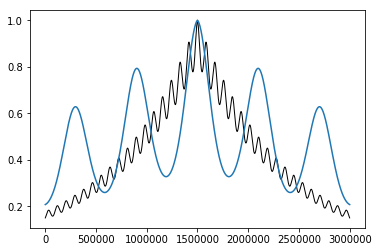

In [3]:
plt.plot(current_t,k1, 'k-', lw=1)
plt.plot(current_t,k2)

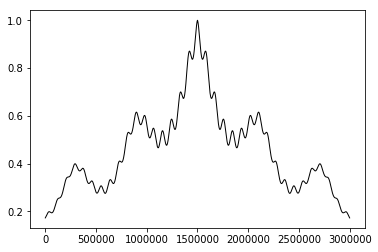

In [4]:
plt.plot(current_t,0.6*k1+0.4*k2, 'k-', lw=1)

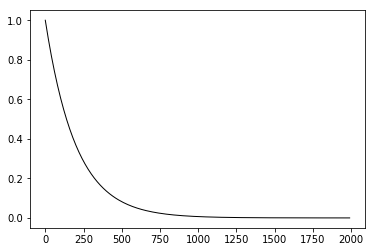

In [5]:
g = 200
d = np.arange(0,2000,10)
k3 = np.exp(-d/g)
plt.plot(d,k3, 'k-', lw=1)

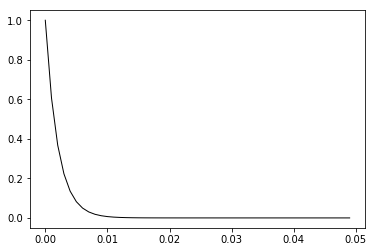

In [6]:
l3 = 0.002
d = np.arange(0,0.05,0.001)
k3 = np.exp(-d/l3)
plt.plot(d,k3, 'k-', lw=1)

In [7]:
### parameters ###
l1 = 60*60*24*10
l2 = 60*60*24*30
l3 = 0.002
g = 200
a1 = 5
a2 = 1
b1 = 0.3
b2 = 0.2
b3 = 0.5
d = 200
sigma2 = 0.01
tol = 0.05
num = 10
switch = 3

In [8]:
path = 'C:/Users/glius/Downloads/abdominal_data/1pb3ge61/gps'
filelist = [path + "/"+ os.listdir(path)[j] for j in range(len(os.listdir(path)))]
rawMat = GPS2MobMat(filelist,itrvl=10,accuracylim=51, r=None, w=None,h=None)
MobMat = InferMobMat(rawMat,itrvl=10,r=None)

Read in all GPS csv files...
Collapse data within 10 second intervals...
Extract flights and pauses ...
Infer unclassified windows ...
Merge consecutive pauses and bridge gaps ...


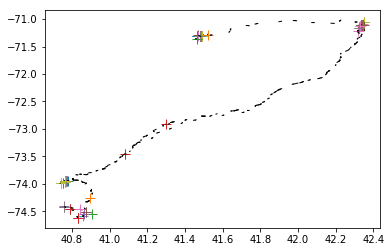

In [9]:
for i in range(np.shape(MobMat)[0]):
  if MobMat[i,0]==1:
    plt.plot([MobMat[i,1],MobMat[i,4]], [MobMat[i,2], MobMat[i,5]], 'k-', lw=1)
  if MobMat[i,0]==2:
    plt.plot(MobMat[i,1],MobMat[i,2],"+",ms=10)

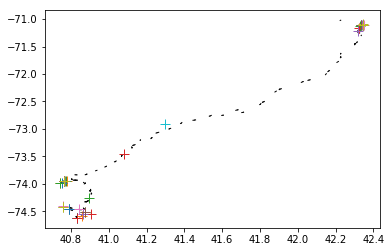

In [10]:
BV_set = BV_select(MobMat,sigma2,tol,d)["BV_set"]
flight_table, pause_table, mis_table = create_tables(MobMat, BV_set)
for i in range(np.shape(flight_table)[0]):
  plt.plot([flight_table[i,1],flight_table[i,4]], [flight_table[i,2], flight_table[i,5]], 'k-', lw=1)
for i in range(np.shape(pause_table)[0]):
  plt.plot(pause_table[i,1],pause_table[i,2],"+",ms=10)

In [11]:
[sum(BV_set[:,0]==1),sum(BV_set[:,0]==2)]

[216, 79]

Imputing missing trajectories...
Tidying up the trajectories...


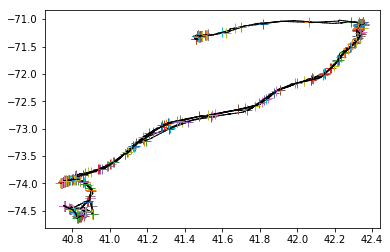

In [12]:
imp_table= ImputeGPS(MobMat,BV_set,"GLC",switch)
traj = Imp2traj(imp_table,MobMat)
for i in range(np.shape(traj)[0]):
  if traj[i,0]==1:
    plt.plot([traj[i,1],traj[i,4]], [traj[i,2], traj[i,5]], 'k-', lw=1)
  if traj[i,0]==2:
    plt.plot(traj[i,1],traj[i,2],"+",ms=10)

In [33]:
def GetStats(traj,option):
  sys.stdout.write("Calculating the summary stats..." + '\n')
  ObsTraj = traj[traj[:,7]==1,:]
  hours = [datetime.fromtimestamp((ObsTraj[i,3]+ObsTraj[i,6])/2).hour for i in range(ObsTraj.shape[0])]
  hours = np.array(hours)
  home_pauses = ObsTraj[((hours>=19)+(hours<=9))*ObsTraj[:,0]==2,:]
  loc_x,loc_y,num_xy,t_xy = num_sig_places(home_pauses,20)
  home_index = num_xy.index(max(num_xy))
  home_x, home_y = loc_x[home_index],loc_y[home_index]
  
  summary_stats = []
  if option == "hourly":
    ## find starting and ending time
    start_time = datetime.fromtimestamp(traj[0,3])
    start_time = start_time + timedelta(hours=1) - timedelta(minutes=start_time.minute,
                        seconds=start_time.second, microseconds=start_time.microsecond)
    start_stamp = datetime.timestamp(start_time)
    end_time = datetime.fromtimestamp(traj[-1,3])
    end_time = end_time - timedelta(minutes=end_time.minute,
                        seconds=end_time.second, microseconds=end_time.microsecond)
    end_stamp = datetime.timestamp(end_time)
    ## start_time, end_time are exact points (if it is 2019-3-8 11hr, then 11 shouldn't be included)
    h = (end_stamp - start_stamp)/60/60
    window = 60*60
    
  if option == "daily":
    ## find starting and ending time
    start_time = datetime.fromtimestamp(traj[0,3])
    start_time = start_time + timedelta(days=1) - timedelta(hours=start_time.hour, minutes=start_time.minute,
                        seconds=start_time.second, microseconds=start_time.microsecond)
    start_stamp = datetime.timestamp(start_time)
    end_time = datetime.fromtimestamp(traj[-1,3])
    end_time = end_time - timedelta(hours= end_time.hour, minutes=end_time.minute,
                        seconds=end_time.second, microseconds=end_time.microsecond)
    end_stamp = datetime.timestamp(end_time)
    ## start_time, end_time are exact points (if it is 2019-3-8 11hr, then start from 2019-3-9)
    h = (((end_stamp - start_stamp)/60/60)-1)/24
    window = 60*60*24

  for i in range(int(h)):
    t0 = start_stamp + i*window
    t1 = start_stamp + (i+1)*window
    current_t = datetime.fromtimestamp(t0)
    year,month,day,hour = current_t.year, current_t.month,current_t.day,current_t.hour
    ## take a subset, the starting point of the last traj <t1 and the ending point of the first traj >t0
    index = (traj[:,3]<t1)*(traj[:,6]>t0)
    temp = traj[index,:]
    if sum(index)==1:
      p0 = (t0-temp[0,3])/(temp[0,6]-temp[0,3])
      p1 = (t1-temp[0,3])/(temp[0,6]-temp[0,3])
      x0 = temp[0,1]; x1 = temp[0,4]; y0 = temp[0,2]; y1 = temp[0,5]
      temp[0,1] = (1-p0)*x0+p0*x1
      temp[0,2] = (1-p0)*y0+p0*y1
      temp[0,3] = t0
      temp[0,4] = (1-p1)*x0+p1*x1
      temp[0,5] = (1-p1)*y0+p1*y1
      temp[0,6] = t1
    else:
      p0 = (temp[0,6]-t0)/(temp[0,6]-temp[0,3])
      p1 = (t1-temp[-1,3])/(temp[-1,6]-temp[-1,3])
      temp[0,1] = (1-p0)*temp[0,4]+p0*temp[0,1]
      temp[0,2] = (1-p0)*temp[0,5]+p0*temp[0,2]
      temp[0,3] = t0
      temp[-1,4] = (1-p1)*temp[-1,1] + p1*temp[-1,4]
      temp[-1,5] = (1-p1)*temp[-1,2] + p1*temp[-1,5]
      temp[-1,6] = t1

    missing_length = sum((temp[:,6]-temp[:,3])[temp[:,7]==0])
    d_home_1 = great_circle_dist(home_x,home_y,temp[:,1],temp[:,2])
    d_home_2 = great_circle_dist(home_x,home_y,temp[:,4],temp[:,5])
    d_home = (d_home_1+d_home_2)/2
    max_dist_home = max(np.concatenate((d_home_1,d_home_2)))
    time_at_home = sum((temp[:,6]-temp[:,3])[d_home<=50])
    mov_vec = great_circle_dist(temp[:,4],temp[:,5],temp[:,1],temp[:,2])
    flight_d_vec = mov_vec[temp[:,0]==1]
    pause_d_vec = mov_vec[temp[:,0]==2]
    flight_t_vec = (temp[:,6]-temp[:,3])[temp[:,0]==1]
    pause_t_vec = (temp[:,6]-temp[:,3])[temp[:,0]==2]
    total_pause_time =  sum(pause_t_vec)
    total_flight_time =  sum(flight_t_vec)
    dist_traveled = sum(mov_vec)
    if len(flight_d_vec)>0:
      av_f_len = np.mean(flight_d_vec)
      sd_f_len = np.std(flight_d_vec)
      av_f_dur = np.mean(flight_t_vec)
      sd_f_dur = np.std(flight_t_vec)
    if len(flight_d_vec)==0:
      av_f_len = 0
      sd_f_len = 0
      av_f_dur = 0
      sd_f_dur = 0
    if option=="hourly":
      summary_stats.append([year,month,day,hour,missing_length/60,total_pause_time/60,total_flight_time/60,time_at_home/60,
                            max_dist_home, dist_traveled,av_f_len,sd_f_len,av_f_dur/60,sd_f_dur/60])
    if option=="daily":
      temp_pause = temp[temp[:,0]==2,:]
      centroid_x = np.dot((temp_pause[:,6]-temp_pause[:,3])/total_pause_time,temp_pause[:,1])
      centroid_y = np.dot((temp_pause[:,6]-temp_pause[:,3])/total_pause_time,temp_pause[:,2])
      r_vec = great_circle_dist(centroid_x,centroid_y,temp_pause[:,1],temp_pause[:,2])
      radius = np.dot((temp_pause[:,6]-temp_pause[:,3])/total_pause_time,r_vec)
      loc_x,loc_y,num_xy,t_xy = num_sig_places(temp_pause,50)
      num_sig = sum(np.array(t_xy)/60>15)
      t_sig = np.array(t_xy)[np.array(t_xy)/60>15]
      p = t_sig/sum(t_sig)
      entropy = -sum(p*np.log(p+0.00001))
      if temp.shape[0]==1:
        diameter = 0
      else:
        D = pairwise_great_circle_dist(temp[:,[1,2]])
        diameter = max(D)
      summary_stats.append([year,month,day,missing_length/3600,total_pause_time/3600,total_flight_time/3600,time_at_home/3600,
                            max_dist_home/1000, dist_traveled/1000,av_f_len/1000,sd_f_len/1000,av_f_dur/3600,sd_f_dur/3600,radius/1000,
                            diameter/1000, num_sig, entropy])
      
  summary_stats = pd.DataFrame(np.array(summary_stats))
  if option == "hourly":
    summary_stats.columns = ["year","month","day","hour","missing_time","pause_time","flight_time","home_time","max_dist_home",
                          "dist_traveled","av_flight_length","sd_flight_length","av_flight_duration","sd_flight_duration"]
  if option == "daily":
    summary_stats.columns = ["year","month","day","missing_time","pause_time","flight_time","home_time","max_dist_home",
                            "dist_traveled","av_flight_length","sd_flight_length","av_flight_duration","sd_flight_duration",
                            "radius","diameter","num_sig_places","entropy"]
  return(summary_stats)

In [34]:
hourly = GetStats(traj,"hourly")
hourly.head(10)

Calculating the summary stats...


,year,month,day,hour,missing_time,pause_time,flight_time,home_time,max_dist_home,dist_traveled,av_flight_length,sd_flight_length,av_flight_duration,sd_flight_duration
0,2016.0,9.0,16.0,18.0,54.000000,15.766667,44.233333,0.0,53902.259071,55005.332677,625.060599,668.536437,0.502652,0.331214
1,2016.0,9.0,16.0,19.0,54.000000,8.233333,51.766667,0.0,152448.861395,107538.094172,1168.891296,861.222850,0.562681,0.349494
2,2016.0,9.0,16.0,20.0,55.000000,17.266667,42.733333,0.0,238560.306514,92590.296511,1040.338277,1024.018370,0.480150,0.270419
3,2016.0,9.0,16.0,21.0,54.000000,12.733333,47.266667,0.0,295104.294535,66753.198859,681.154122,591.169036,0.482313,0.314365
4,2016.0,9.0,16.0,22.0,57.833333,49.350000,10.650000,0.0,295564.417131,8846.235093,384.592442,303.023006,0.463043,0.286321
5,2016.0,9.0,16.0,23.0,58.500000,50.833333,9.166667,0.0,295194.061006,5754.793511,319.705476,245.506398,0.509259,0.311667
6,2016.0,9.0,17.0,0.0,57.833333,45.500000,14.500000,0.0,295104.841812,10109.388129,361.046185,302.419365,0.517857,0.316821
7,2016.0,9.0,17.0,1.0,53.833333,54.166667,5.833333,0.0,295080.376515,3149.943730,314.965892,337.165211,0.583333,0.271314
8,2016.0,9.0,17.0,2.0,54.166667,50.666667,9.333333,0.0,295076.609746,3541.795104,272.445777,231.141556,0.717949,0.503766
9,2016.0,9.0,17.0,3.0,53.166667,57.000000,3.000000,0.0,294912.273245,1492.870207,373.217552,261.425488,0.750000,0.533594


In [35]:
daily = GetStats(traj,"daily")
daily.head(10)

Calculating the summary stats...


,year,month,day,missing_time,pause_time,flight_time,home_time,max_dist_home,dist_traveled,av_flight_length,sd_flight_length,av_flight_duration,sd_flight_duration,radius,diameter,num_sig_places,entropy
0,2016.0,9.0,17.0,22.680556,19.261111,4.738889,0.000000,337.592863,273.813548,0.529615,0.498103,0.009166,0.005875,22.096942,57.935446,9.0,1.614858
1,2016.0,9.0,18.0,22.502778,19.430556,4.569444,0.565556,295.671460,378.408035,0.772253,0.785610,0.009325,0.005693,31.988140,296.280129,7.0,0.905010
2,2016.0,9.0,19.0,22.644444,20.908333,3.091667,13.268056,1.222754,109.495280,0.336887,0.316706,0.009513,0.005946,0.143774,2.217263,8.0,1.168656
3,2016.0,9.0,20.0,22.922222,21.000000,3.000000,13.408333,1.963549,107.452215,0.337885,0.308709,0.009434,0.005981,0.525049,3.026951,13.0,1.838935
4,2016.0,9.0,21.0,22.488889,21.988889,2.011111,16.831944,1.096699,59.987857,0.294040,0.278805,0.009858,0.007073,0.148845,2.042696,9.0,1.033039
5,2016.0,9.0,22.0,22.644444,20.520556,3.479444,13.766389,2.089601,120.247016,0.330330,0.323734,0.009559,0.005740,0.374732,3.239163,8.0,1.196077
6,2016.0,9.0,23.0,23.174722,20.278056,3.721944,7.822500,4.707203,114.644571,0.300885,0.277168,0.009769,0.006046,0.693124,5.732328,18.0,2.336475
7,2016.0,9.0,24.0,22.566944,17.208333,6.791667,8.002778,100.915899,392.826280,0.546346,0.573797,0.009446,0.005802,45.962148,102.594010,9.0,1.598940
8,2016.0,9.0,25.0,22.977778,21.554167,2.445833,14.950000,3.466355,86.476762,0.345892,0.304075,0.009783,0.005404,0.254406,4.446294,9.0,1.182575
9,2016.0,9.0,26.0,22.633333,21.473611,2.526389,15.600000,1.319948,77.901399,0.303103,0.314334,0.009830,0.006098,0.079134,2.487276,4.0,0.725963
